<a href="https://colab.research.google.com/github/petroDavydov/goit-DeepLearningForComputerVisionAndNLP/blob/main/eda_pinguinius.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [157]:
from dataclasses import dataclass

import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# filter warnings
warnings.filterwarnings('ignore')


Завантажимо набір даних і попередньо переглянемо:



In [158]:
df = pd.read_csv('/content/Module_2_Lecture_2_Class_penguins.csv')

df.sample(5, random_state=42)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
194,Gentoo,Biscoe,45.3,13.7,210.0,4300.0,female
157,Gentoo,Biscoe,46.5,13.5,210.0,4550.0,female
225,Gentoo,Biscoe,46.5,14.8,217.0,5200.0,female
208,Gentoo,Biscoe,43.8,13.9,208.0,4300.0,female
318,Chinstrap,Dream,50.9,19.1,196.0,3550.0,male


Виведемо базову інформацію про набір даних.

In [159]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


З колонки Non-Null Count бачимо, що тільки декілька рядків даних мають пропущені значення. Можемо видалити їх з датасету.

In [160]:
df = df.dropna().reset_index(drop=True)
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male
...,...,...,...,...,...,...,...
328,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male
329,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female
330,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male
331,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male


Подивимось на розподіл цільової змінної.

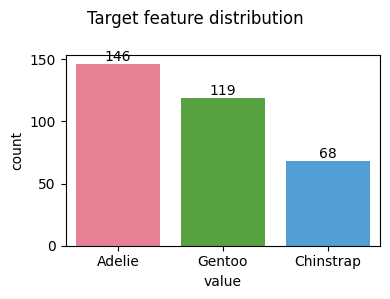

In [161]:
plt.figure(figsize=(4,3))
ax = sns.countplot(data=df, x='species', palette='husl')
for i in ax.containers:
    ax.bar_label(i)
    ax.set_xlabel("value")
    ax.set_ylabel("count")

plt.suptitle("Target feature distribution")

plt.tight_layout()
plt.show()


# ***💡 У випадках, як цей, коли класи не сильно дисбалансовані, підходящою метрикою є аccuracy. Оскільки точність вимірює частку правильно класифікованих прикладів у загальній їх кількості, використання цієї метрики є доцільним для оцінки ефективності цієї моделі.***

# Подивимось розподіл категоріальної змінної ***island.***

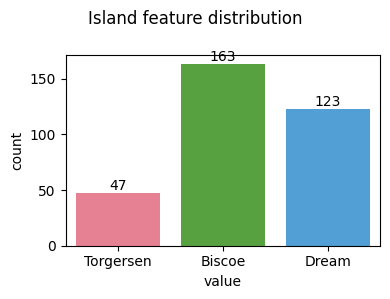

In [162]:
plt.figure(figsize=(4,3))
ax = sns.countplot(data=df, x='island', palette = 'husl')
for i in ax.containers:
    ax.bar_label(i)
    ax.set_xlabel("value")
    ax.set_ylabel("count")

plt.suptitle("Island feature distribution")

plt.tight_layout()
plt.show()

# ***💡 Дисбаланс класів цієї змінної може вказувати на дисбаланс у розподілі даних у реальному житті. У цьому випадку необхідно бути обережними, щоб не видаляти записи вхідних даних або надлишково їх дискретизувати (oversample), оскільки це може внести зміщення в нашу модель.***

# **Подивимось на попарний розподіл числових ознак.**

<Figure size 500x500 with 0 Axes>

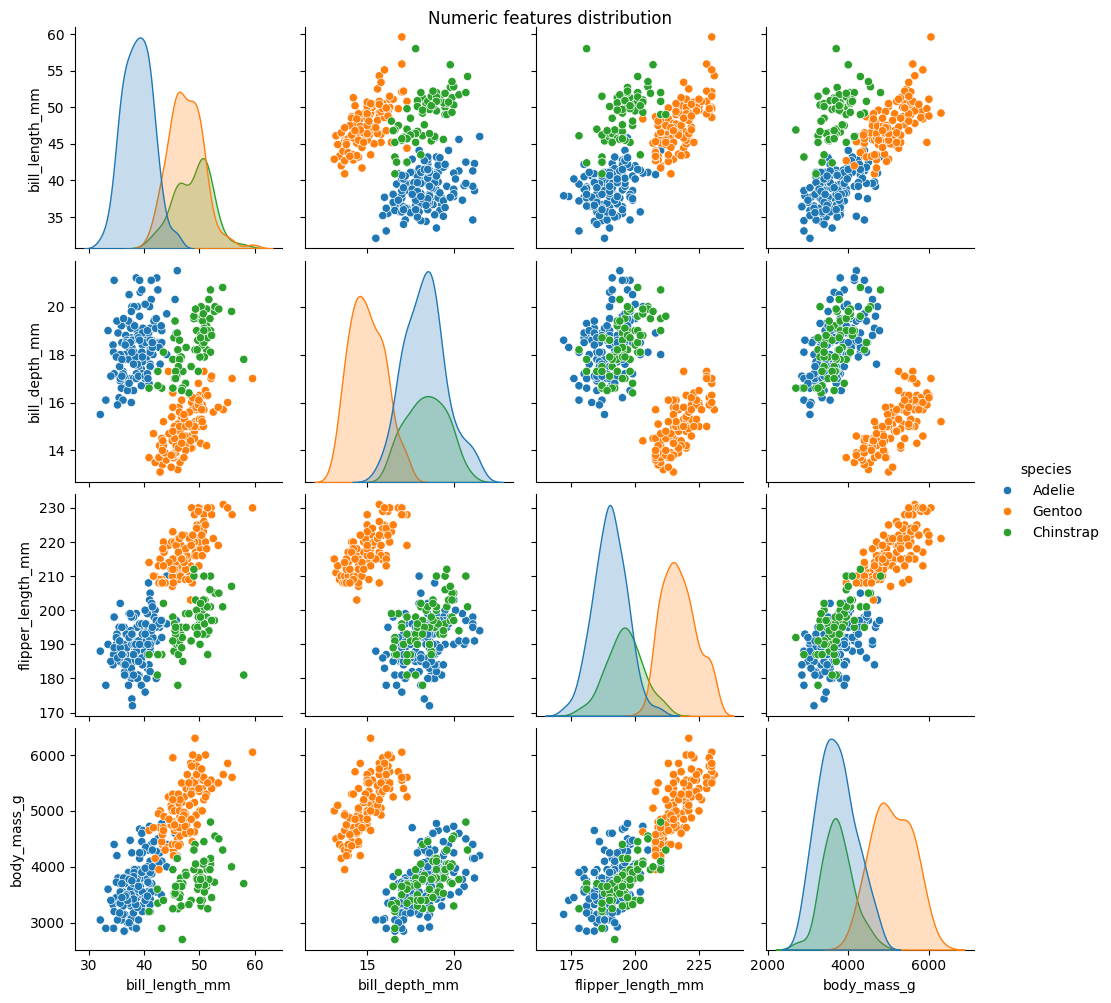

In [163]:
plt.figure(figsize=(5,5))
sns.pairplot(data=df, hue='species').fig.suptitle('Numeric features distribution', y=1)
plt.show()


# ***Підготовка ознак моделі***

Для моделювання цієї задачі залишимо тільки числові змінні.

In [164]:
features = ['species', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

df = df.loc[:, features]

df

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
3,Adelie,36.7,19.3,193.0,3450.0
4,Adelie,39.3,20.6,190.0,3650.0
...,...,...,...,...,...
328,Chinstrap,55.8,19.8,207.0,4000.0
329,Chinstrap,43.5,18.1,202.0,3400.0
330,Chinstrap,49.6,18.2,193.0,3775.0
331,Chinstrap,50.8,19.0,210.0,4100.0


💡 В якості “завдання із зірочкою” можете залишити усі ознаки, що є в наборі даних, та опрацювати їх таким чином, щоб замість категоріальних змінних мати числові.

Перетворимо категоріальну таргетну змінну в числову.



In [165]:
df.loc[df['species']=='Adelie', 'species']=0
df.loc[df['species']=='Gentoo', 'species']=1
df.loc[df['species']=='Chinstrap', 'species']=2
df = df.apply(pd.to_numeric)

df.head(2)


,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,0,39.1,18.7,181.0,3750.0
1,0,39.5,17.4,186.0,3800.0


Представимо матрицю ознак
X та вектор таргетової змінної
y як numpy-масив.

In [166]:
X = df.drop('species', axis =1).values
y = df['species'].values

X
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

Щоб гарантувати, що ознаки будуть представлені в одному масштабі, використаємо StandardScaler.

In [167]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X


array([[-0.89604189,  0.7807321 , -1.42675157, -0.56847478],
       [-0.82278787,  0.11958397, -1.06947358, -0.50628618],
       [-0.67627982,  0.42472926, -0.42637319, -1.1903608 ],
       ...,
       [ 1.02687621,  0.52644436, -0.56928439, -0.53738048],
       [ 1.24663828,  0.93330475,  0.64546078, -0.13315457],
       [ 1.13675725,  0.7807321 , -0.2120064 , -0.53738048]])

Розділимо дані на тренувальні та тестові.

In [168]:
X_train , X_test , y_train , y_test = train_test_split(X, y, random_state = 42, test_size =0.33, stratify=y)

X_train
X_test
y_train
y_test

array([2, 0, 1, 1, 2, 2, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 2, 1, 2, 1,
       1, 0, 0, 0, 2, 1, 1, 2, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 2, 1, 1, 0, 2, 1, 0, 1, 0, 1, 0, 1, 2, 1, 2, 2, 0, 1, 2, 1, 1,
       2, 0, 0, 2, 2, 0, 1, 0, 0, 2, 1, 0, 2, 2, 2, 1, 0, 2, 1, 2, 1, 0])

Для подальшої роботи з інструментами фреймворку PyTorch перетворимо дані з numpy-масивів у torch.tensor.

In [169]:
X_train = torch.Tensor(X_train).float()
y_train = torch.Tensor(y_train).long()

X_test = torch.Tensor(X_test).float()
y_test = torch.Tensor(y_test).long()

print(X_train[:1])
print(y_train[:10])


tensor([[ 1.2650,  0.9842, -0.3549, -0.8172]])
tensor([2, 0, 1, 1, 1, 2, 0, 1, 1, 0])


"-----------------------------------------"

# ***Задача багатокласової класифікації. Моделювання та аналіз результатів***



Підготовка моделі

Створимо клас нейронної мережі для вирішення задачі багатокласової класифікації.

In [170]:
class LinearModel(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim=20, out_dim=3):
        super().__init__()

        self.features = torch.nn.Sequential(

            nn.Linear(in_dim, hidden_dim),
            torch.nn.ReLU(),

            nn.Linear(hidden_dim, out_dim),
            nn.Softmax()
        )

    def forward(self, x):
        output = self.features(x)
        return output


In [171]:
# # Second variant

# class LinearModel(torch.nn.Module):
#     def __init__(self, in_dim, hidden_dim=20, out_dim=3):
#         super().__init__()

#         self.features = torch.nn.Sequential(
#             nn.Linear(in_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, out_dim)   # без Softmax
#         )

#     def forward(self, x):
#         return self.features(x)


***Ініціалізуємо модель.***

In [172]:
model = LinearModel(X_train.shape[1], 20, 3)


In [173]:
criterion = nn.CrossEntropyLoss()


В якості оптимізаційного алгоритму використаємо Stochastic Gradient Descent (SGD).

In [174]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


Кількість епох визначимо рівною 400.

In [175]:
num_epoch = 350


Створимо декілька об’єктів-списків, у які будемо зберігати результати тренування: accuracy та loss.

In [176]:
train_loss = []
test_loss = []

train_accs = []
test_accs = []


# ***Тренування***

In [177]:
# model.train()
# outputs = model(X_train)
# loss = criterion(outputs, y_train)
# train_loss.append(loss.cpu().detach().numpy())
# optimizer.zero_grad()
# loss.backward()
# optimizer.step()
# acc = 100 * torch.sum(y_train==torch.max(outputs.data, 1)[1]).double() / len(y_train)
# train_accs.append(acc)


# ***Тестування***

In [178]:
model.eval()


LinearModel(
  (features): Sequential(
    (0): Linear(in_features=4, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=3, bias=True)
    (3): Softmax(dim=None)
  )
)

***Робимо forward pass та розраховуємо функцію втрат, але не робимо крок оптимізації. Розраховуємо точність на тестових даних.***

In [179]:
# outputs = model(X_test)

# loss = criterion(outputs, y_test)
# test_loss.append(loss.cpu().detach().numpy())

# acc = 100 * torch.sum(y_test==torch.max(outputs.data, 1)[1]).double() / len(y_test)
# test_accs.append(acc)


# ***Отже, маємо наступний цикл, в якому тренуємо і тестуємо нашу модель.***

In [180]:
for epoch in range(num_epoch):

    # train the model
    model.train()

    outputs = model(X_train)

    loss = criterion(outputs, y_train)
    train_loss.append(loss.cpu().detach().numpy())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc = 100 * torch.sum(y_train==torch.max(outputs.data, 1)[1]).double() / len(y_train)
    train_accs.append(acc)

    if (epoch+1) % 10 == 0:
        print ('Epoch [%d/%d] Loss: %.4f   Acc: %.4f'
                       %(epoch+1, num_epoch, loss.item(), acc.item()))

    # test the model

    model.eval()
    with torch.no_grad():
        outputs = model(X_test)

        loss = criterion(outputs, y_test)
        test_loss.append(loss.cpu().detach().numpy())

        acc = 100 * torch.sum(y_test==torch.max(outputs.data, 1)[1]).double() / len(y_test)
        test_accs.append(acc)


Epoch [10/350] Loss: 1.0378   Acc: 89.6861
Epoch [20/350] Loss: 1.0267   Acc: 92.3767
Epoch [30/350] Loss: 1.0155   Acc: 91.9283
Epoch [40/350] Loss: 1.0043   Acc: 91.9283
Epoch [50/350] Loss: 0.9931   Acc: 91.0314
Epoch [60/350] Loss: 0.9820   Acc: 91.0314
Epoch [70/350] Loss: 0.9709   Acc: 90.1345
Epoch [80/350] Loss: 0.9600   Acc: 90.5830
Epoch [90/350] Loss: 0.9492   Acc: 89.6861
Epoch [100/350] Loss: 0.9386   Acc: 90.1345
Epoch [110/350] Loss: 0.9281   Acc: 90.1345
Epoch [120/350] Loss: 0.9179   Acc: 90.5830
Epoch [130/350] Loss: 0.9080   Acc: 90.5830
Epoch [140/350] Loss: 0.8984   Acc: 90.5830
Epoch [150/350] Loss: 0.8890   Acc: 90.5830
Epoch [160/350] Loss: 0.8800   Acc: 90.5830
Epoch [170/350] Loss: 0.8712   Acc: 89.2377
Epoch [180/350] Loss: 0.8628   Acc: 88.7892
Epoch [190/350] Loss: 0.8548   Acc: 88.3408
Epoch [200/350] Loss: 0.8471   Acc: 87.8924
Epoch [210/350] Loss: 0.8397   Acc: 86.9955
Epoch [220/350] Loss: 0.8327   Acc: 86.9955
Epoch [230/350] Loss: 0.8259   Acc: 86.99

# ***Аналіз результатів***

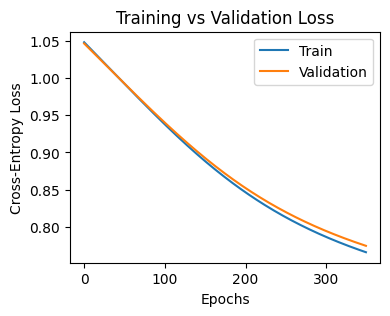

In [181]:
plt.figure(figsize=(4, 3))
plt.plot(train_loss, label='Train')
plt.plot(test_loss, label='Validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training vs Validation Loss')
plt.show()


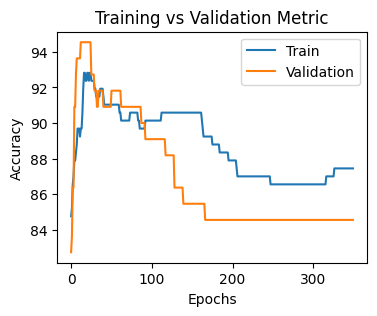

In [182]:
plt.figure(figsize=(4, 3))
plt.plot(train_accs, label='Train')
plt.plot(test_accs, label='Validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Metric')
plt.show()
